# Телеком. Предсказание ухода клиентов

**В данной работе необходимо построить модель машинного обучения способную предсказывать возможность ухода клиента в ближайшее время к другому оператору связи.**<br>
Заказчик работы оператор связи «Ниединогоразрыва.ком» хочет использовать предсказания модели для предложения потенциальным "сбегающим" клиентам различных бонусных предложений, с целью сохранения клиентов.<br>
В ходе работы надо будет осмотреть имеющиеся данные, очистить их и подготовить для работы с моделями машинного обучения. Также необходимо будет выделить в данных целевой признак и  отделить от данных часть для тестирования лучшей модели. Затем мы подберем модель и ее параметры, которые покажут лучшие результаты на наших данных и проверим ее на тестовой выборке.

## Обзор и исследование данных

Для начала загрузим имеющиеся файлы и внимательно рассмотрим данные.

In [ ]:
import pandas as pd
import numpy as np
import scipy
import os
import pprint
from ydata_profiling import ProfileReport
import phik

import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.graph_objs as go
import plotly.express as px
from pylab import rcParams

rcParams["figure.figsize"] = 12, 6

from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    RandomizedSearchCV,
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, precision_recall_curve

from catboost import CatBoostClassifier, Pool

RANDOM_STATE = 130323

In [2]:
path_main = "..\\data_sets\\final_telecom\\"
path_server = "/datasets/final_provider/"

При загрузке данных сразу определим столбец `customerID` в качестве индекса для каждого набора данных.

In [ ]:
def load(file_name, datatime_column=None):
    if os.path.exists(path_main):
        return pd.read_csv(
            path_main + file_name, parse_dates=datatime_column, index_col=["customerID"]
        )
    elif os.path.exists(path_server):
        return pd.read_csv(
            path_server + file_name,
            parse_dates=datatime_column,
            index_col=["customerID"],
        )
    else:
        print("Check path or file")

In [ ]:
contract = load("contract.csv", ["BeginDate"])
internet = load("internet.csv")
personal = load("personal.csv")
phone = load("phone.csv")

In [ ]:
report_names = [
    'Overview of "contract" dataFrame',
    'Overview of "internet" dataFrame',
    'Overview of "personal" dataFrame',
    'Overview of "phone" dataFrame',
]
i = 0
for df in [contract, internet, personal, phone]:
    display(ProfileReport(df, title=report_names[i]))
    i += 1

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Мы имеем 4 датасета с личными данными о клиентах, их контрактах, подключенных услугах и наличия стационарной телефонной связи от компании «Ниединогоразрыва.ком». У каждого датасета на месте индексов находятся значения ID клиента.

Взглянем на каждый датасет отдельно:
- Contract - датасет размером 7043 строк и 7 столбцов с характеристиками договора на услуги оператора. Здесь можно обратить внимание на столбец `EndDate`, большая часть значений которого явлеется значением `No`, а остальные значения это даты окончания договоров, емеет формат object - Предположительно, этот столбец является нашим целевым признаком, значения `No` показывают, что договор еще действует, а значения с датой означает, дату завершения договора и уход клиента. Столбец `TotalCharges` при наличии числовых значений имеет формат object. При поверхностном взгляде пропусков, выбросов и корреляций не видно.
- Internet - датасет размером 5517 строк и 7 столбцов, показывающий кто из пользователей какие дополнительные услуги подключал и каким типом интернета пользовался. Все столбцы имеют категориальные или булевы значения. Пропусков или некорректных значений не замечено.
- Perconal - датасет размером 7043 строк и 4 столбцов, показывающий персональные данные пользователей относящиеся к полу и возрасту, но значения столбцов лучше уточнить. Все столбцы имеют категориальные или булевы значения. Пропусков или некорректных значений не замечено.
- Phone - датасет размером 6361 строк и 1го столбца, показывающий наличие подключения стационарной телефонной связи. Имеет булевы значения, показывающие подключена ли телефонная связь или нет. Пропусков или некорректных значений не замечено.

Также название столбцов всех таблиц необходимо привести к формату snake_case и убрать заглавные буквы.

### Предполагаемый план работы 

 <a id='1'></a>
1. Работа с данными:
- Исправление названий столбцов;
- Работа с неверными форматами данных;
- Выделение дополнительных признаков;
- Выделение целевого признака;
- Объединение таблиц и заполнение недостающих данных после объединения;
- Отбор ненужных столбцов с данным по смысловому признаку.
2. Подготовка к работе моделей:
- Выделение тестовой части данных;
- Подготовка параметра scoring при необходимости;
- Формирование ColumnTransformer для перевода данных в числовой формат;
- Определение списка моделей и набора их параметров;
- Формирование пайплайна;
3. Обучение моделей ( Обучение моделей, подбор наилучших парметров, сравнение результатов, анализ значимости признаков и выбор лучшей модели на валидации)

4. Тестирование лучшей модели

5. Запись пайплайна с лучшей обученой моделью при необходимости.

## Предобработка данных

### Исправление названий признаков

Поправим название признаков во всех датафреймах на snake_case.

In [ ]:
personal.columns = personal.columns.str.replace("gender", "Gender")

for data in [contract, personal, phone, internet]:
    data.columns = (
        data.columns.str.replace(r"([A-Z])", r" \1")
        .str.lower()
        .str.replace(" ", "_")
        .str[1:]
    )
    data.index.name = "customer_id"
personal.columns

/tmp/ipykernel_69/2363969357.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  data.columns.str


Index(['gender', 'senior_citizen', 'partner', 'dependents'], dtype='object')

### Работа со столбцом `total_charges`

У столбца `total_charges` датафрейма `contract` формат `object`, хотя в нем цифровые значения. Переведем его в числовой формат, а все некорректные значения заменим пропусками. Затем выведем те строки, в которых мы столкнулись с некорректными значениями столбца `total_charges` 

In [ ]:
contract.total_charges = pd.to_numeric(contract.total_charges, errors="coerce")
contract[contract.total_charges.isna() == True]

begin_date end_date      type paperless_billing  \
customer_id                                                   
4472-LVYGI  2020-02-01       No  Two year               Yes   
3115-CZMZD  2020-02-01       No  Two year                No   
5709-LVOEQ  2020-02-01       No  Two year                No   
4367-NUYAO  2020-02-01       No  Two year                No   
1371-DWPAZ  2020-02-01       No  Two year                No   
7644-OMVMY  2020-02-01       No  Two year                No   
3213-VVOLG  2020-02-01       No  Two year                No   
2520-SGTTA  2020-02-01       No  Two year                No   
2923-ARZLG  2020-02-01       No  One year               Yes   
4075-WKNIU  2020-02-01       No  Two year                No   
2775-SEFEE  2020-02-01       No  Two year               Yes   

                        payment_method  monthly_charges  total_charges  
customer_id                                                             
4472-LVYGI   Bank transfer (automatic)            52.55            NaN  
3115-CZMZD                Mailed check            20.25            NaN  
5709-LVOEQ                Mailed check            80.85            NaN  
4367-NUYAO                Mailed check            25.75            NaN  
1371-DWPAZ     Credit card (automatic)            56.05            NaN  
7644-OMVMY                Mailed check            19.85            NaN  
3213-VVOLG                Mailed check            25.35            NaN  
2520-SGTTA                Mailed check            20.00            NaN  
2923-ARZLG                Mailed check            19.70            NaN  
4075-WKNIU                Mailed check            73.35            NaN  
2775-SEFEE   Bank transfer (automatic)            61.90            NaN

Мы четко видим, что все пропущенные значения в столбце `total_charges` - это новые пользователи нашего оператора, которые только заключили договор(`begin_date`) и не успели перечислить оплату. Поэтому заменим все пропуски в данном столбце на нулевые значения. И сразу посмотрим как распредены данные в данном столбце. <a id='2'></a>

In [9]:
contract.total_charges = contract.total_charges.fillna(0)

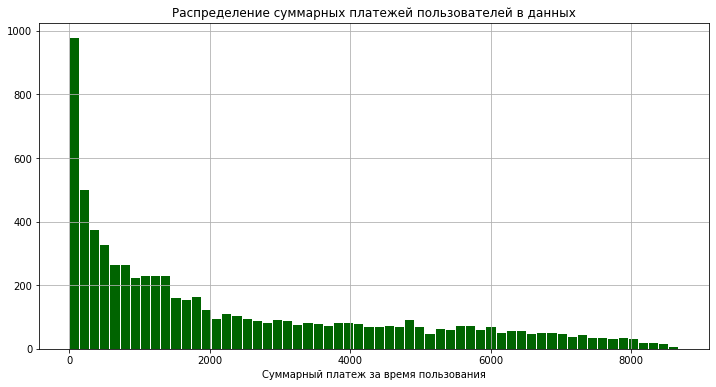

In [ ]:
ax = contract.total_charges.hist(bins=60, rwidth=0.9, color="DarkGreen")
ax.set_title("Распределение суммарных платежей пользователей в данных")
ax.set_xlabel("Суммарный платеж за время пользования");

По диаграмме можно сказать, что большинство пользователей оператора связи «Ниединогоразрыва.ком» пришли к нему не так давно и еще не успели отдать большие суммы. При это видно наличие пользователей, которые либо пользуются услугами давно или платят за услуги намного больше большинства. 

### Работа со столбцом `end_date`,  выделение целевого признака и создание `duration`.

Столбец `end_date` из датафрейма `contract` является по совместительству нашим целевым признаком, в нем значения `No` показывают, что человек еще пользуется услугами оператора, а значения дат показывают, что пользователь не стал продлевать контракт и, видимо, ушел к другому оператору. Выделим из данного столбца столбец с бинарным целевым признаком `out_or_not`, в котором `1` будет показывать, что человек ушел от нашего оператора. <a id='3'></a>

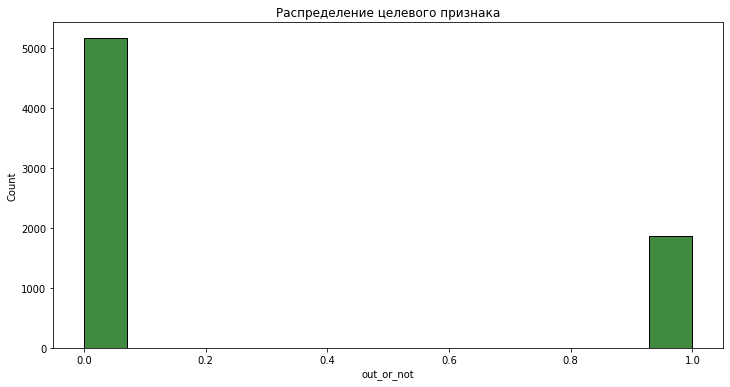

In [ ]:
contract["out_or_not"] = [0 if x == "No" else 1 for x in contract["end_date"]]

sns.histplot(contract["out_or_not"], color="DarkGreen").set_title(
    "Распределение целевого признака"
);

Как мы видим целевой признак у нас не сбалансирован, данных с целевым классом `0` в 2.5 раза больше чем с целевым классом `1`.

Далее из столбцов `end_date` и `begin_date` вычислим какую продолжительность в днях пользователь находится/находился у оператора.<br>
Для этого все значения столбца `end_date`, имеющие значения `No` заменим на дату актуализации данных `2020-02-01 00:00:00`. Затем посчитаем разницу в датах, переведем в числовой формат и запишем в столбец `duration`.

In [ ]:
contract["end_date"] = contract["end_date"].where(
    contract["end_date"] != "No", "2020-02-01 00:00:00"
)

contract["end_date"] = pd.to_datetime(contract["end_date"], format="%Y%m%d %H:%M:%S")

contract["duration"] = (contract["end_date"] - contract["begin_date"]).astype(
    "int64"
) // (24 * 60 * 60 * 10**9)
contract["duration"].head()

customer_id
7590-VHVEG      31
5575-GNVDE    1036
3668-QPYBK      61
7795-CFOCW    1371
9237-HQITU      61
Name: duration, dtype: int64

### Объединение данных

Для нормальной работы модели объеденим все данные в один датафрейм. При этом в таблицах `internet` и `phone` мы имеем меньшее количество строк, так как не все клиенты пользовались интернетом или подключали себе телефонную линию. Поэтому пропуски при объединении в таких строках заполним значением `No`, что будет означать, что пользователь не использовал данную услугу и это будет подходить к тому как заполнена начальная таблица.

In [ ]:
data = contract.join([internet, personal, phone])
data = data.fillna("No")
data.head()

begin_date   end_date            type paperless_billing  \
customer_id                                                           
7590-VHVEG  2020-01-01 2020-02-01  Month-to-month               Yes   
5575-GNVDE  2017-04-01 2020-02-01        One year                No   
3668-QPYBK  2019-10-01 2019-12-01  Month-to-month               Yes   
7795-CFOCW  2016-05-01 2020-02-01        One year                No   
9237-HQITU  2019-09-01 2019-11-01  Month-to-month               Yes   

                        payment_method  monthly_charges  total_charges  \
customer_id                                                              
7590-VHVEG            Electronic check            29.85          29.85   
5575-GNVDE                Mailed check            56.95        1889.50   
3668-QPYBK                Mailed check            53.85         108.15   
7795-CFOCW   Bank transfer (automatic)            42.30        1840.75   
9237-HQITU            Electronic check            70.70         151.65   

             out_or_not  duration internet_service  ... online_backup  \
customer_id                                         ...                 
7590-VHVEG            0        31              DSL  ...           Yes   
5575-GNVDE            0      1036              DSL  ...            No   
3668-QPYBK            1        61              DSL  ...           Yes   
7795-CFOCW            0      1371              DSL  ...            No   
9237-HQITU            1        61      Fiber optic  ...            No   

            device_protection tech_support streaming_t_v streaming_movies  \
customer_id                                                                 
7590-VHVEG                 No           No            No               No   
5575-GNVDE                Yes           No            No               No   
3668-QPYBK                 No           No            No               No   
7795-CFOCW                Yes          Yes            No               No   
9237-HQITU                 No           No            No               No   

             gender senior_citizen  partner dependents multiple_lines  
customer_id                                                            
7590-VHVEG   Female              0      Yes         No             No  
5575-GNVDE     Male              0       No         No             No  
3668-QPYBK     Male              0       No         No             No  
7795-CFOCW     Male              0       No         No             No  
9237-HQITU   Female              0       No         No             No  

[5 rows x 21 columns]

### Обзор и очистка преобразованных данных

Рассмотрим общий датафрейм на предмет мультиколлинеарности признаков, а заодно и посмотрим на степень корреляции признаков и целевого параметра.<br>

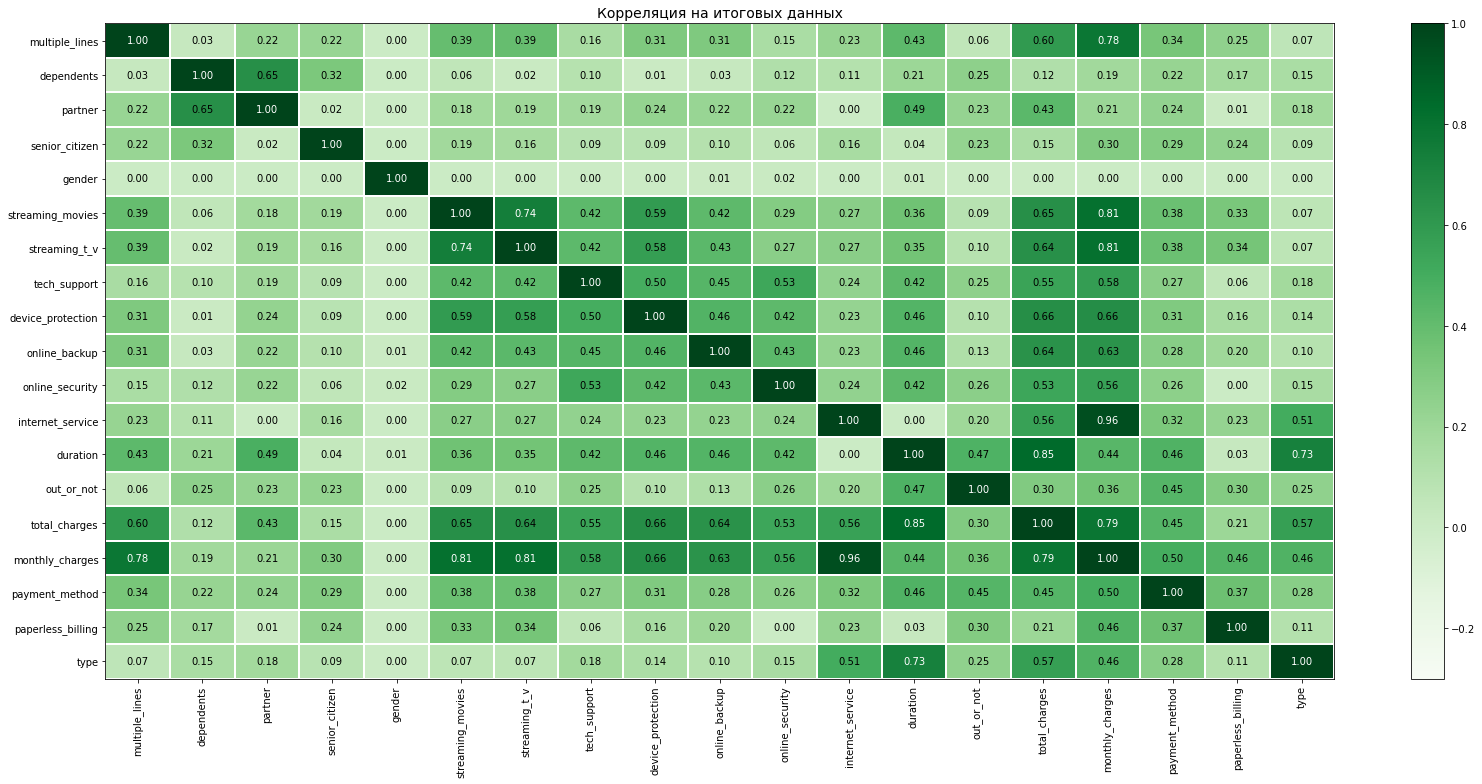

In [ ]:
phik_matrix = phik.phik_matrix(
    data.drop(["begin_date", "end_date"], axis=1),
    interval_cols=["monthly_charges", "total_charges", "duration"],
    bins=20,
)


phik.report.plot_correlation_matrix(
    phik_matrix.values,
    x_labels=phik_matrix.columns,
    y_labels=phik_matrix.index,
    figsize=(23, 11),
    color_map="Greens",
    title="Корреляция на итоговых данных",
    vmin=-0.3,
)

По полученной диаграмме можно сказать, что ни один из признаков не оказывает прямого сильного влияния на целевой признак (уйдет ли клиент).<br>
Относительно мультиколлинеарности можно сказать, что некоторые признаки имеют взаимные зависимости. Отдельно заметим, что новосозданный признак `duration` имеет довольно большую корреляцию с признаком `total_charges`, что является логичной зависимостью - чем дольше пользуешься - тем больше заплатил. Также признак `internet_service` имеет пости 96% корреляцию с признаком `monthly_charges` что показывает сильную зависимость между типом интернет соединения(или его наличия) и месячными платежами пользователей. Из зависимостей, которые хотелось бы отметить это корреляция некоторых услуг провайдера, таких как `streaming_t_v`, `streaming_movies` и `multiple_lines` и месячного платежа `monthly_charges`.<br>
На данном этапе мы избавимся от признаков имеющих временной формат. Также удалим из наших данных признак `monthly_charges` - он является собирательным признаком, в зависимости от количества и видом услуг, которые использует абонент и сильно коррелирует со многоми другими признаками. <br>
Так как большинство моделей с которыми мы собираемся работать не сильно зависят от корреляции признаков между собой - не будем удалять сейчас остальные признаки, но на этапе осмотра важности фичей, влияющих на работу моделей, вспомним о признаках имеющих корреляции друг с другом.

In [ ]:
data = data.drop(["begin_date", "end_date", "monthly_charges"], axis=1)

## Подготовка к работе моделей

В данном проекте мы проверим работу нескольких моделей-классификаторов:
- DecisionTreeClassifier - Модель решающего дерева;
- RandomForestClassifier - Модель случайного леса решающих деревьев;
- LogisticRegression - Простую логистическую регресию;
- SVC - Модель опрных векторов
- CatBoostClassifier - Модель градиентного бустинга.

Модели разделим на группы по предпочтительной предобработке данных. 

### Разделение данных

Выделим целевой признак в отдельную переменную и вынесем часть данных в тестовую часть, помня о дисбалансе целевого признака.

In [ ]:
X = data.drop("out_or_not", axis=1)
y = data["out_or_not"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, shuffle=True, stratify=y
)

[df.shape for df in [X_train, y_train, X_test, y_test]]
# print('sep/n')

[(5282, 17), (5282,), (1761, 17), (1761,)]

### Подготовка объектов ColumnTransformer, Pipeline и гиперпараметров для моделей  

Подготовим объекты предобработки данных для наших моделей:
- Для моделей LogisticRegression и SVC сделаем `transformer_lin_models` - он будет преобразовывать категориальные признаки методом `OneHot`,  а числовые признаки масштабировать с помощью  `MinMaxScaler()`;
- Для моделей DecisionTreeClassifier и RandomForestClassifier сделаем `transformer_tree_models` - он будет преобразовывать категориальные признаки через `OrdinalEncoder()`, а числовые оставит без изменения;
- Для модели CatBoostClassifier вся предобработка данных будет происходить внутри модели.

Обучение моделей и подбор гиперпараметров для моделей из первых 2х групп будем проводить с помощью RandomizedSearchCV. Для модели CatBoostClassifier подбор параметров и кроссвалидация будет осуществляться внутренними методами самой модели.

Также подготовим объекты для записи результатов.

In [ ]:
best_metrics = []

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

categorical = make_column_selector(dtype_include=object)
numeric = make_column_selector(dtype_exclude=object)


transformer_lin_models = ColumnTransformer(
    [
        ("one_hot", OneHotEncoder(drop="first"), categorical),
        ("min_max", MinMaxScaler(), numeric),
    ],
    remainder="passthrough",
)


transformer_tree_models = ColumnTransformer(
    [("ordinal_encod", OrdinalEncoder(), categorical)], remainder="passthrough"
)

Определим модели и их гиперпараметры - неизменные и те, среди которых будем осуществлять подбор.

In [ ]:
clf_log_reg = LogisticRegression(penalty="l2", random_state=RANDOM_STATE)
log_reg_params = {
    "line_clf__C": [0.6, 1, 2, 10],
    "line_clf__max_iter": range(40, 180, 30),
    "line_clf__solver": ["lbfgs", "liblinear", "newton-cg"],
    "line_clf": [clf_log_reg],
}

clf_svc = SVC(cache_size=2000, random_state=RANDOM_STATE)
svc_params = {
    "line_clf__C": np.arange(0.5, 1.3, 0.2),
    "line_clf__kernel": ["poly", "rbf", "sigmoid"],
    "line_clf__gamma": ["scale", "auto"],
    "line_clf__coef0": np.arange(0, 2, 0.5),
    "line_clf": [clf_svc],
}

params_line_models = [log_reg_params, svc_params]


clf_tree = DecisionTreeClassifier(random_state=RANDOM_STATE)
tree_params = {
    "tree_clf__criterion": ["gini", "log_loss"],
    "tree_clf__max_depth": range(3, 16),
    "tree_clf__min_samples_split": range(2, 5),
    "tree_clf": [clf_tree],
}

clf_forest = RandomForestClassifier(warm_start=True, random_state=RANDOM_STATE)
forest_params = {
    "tree_clf__criterion": ["gini", "log_loss"],
    "tree_clf__n_estimators": range(50, 300, 10),
    "tree_clf__max_depth": range(3, 15),
    "tree_clf__min_samples_split": range(2, 5),
    "tree_clf": [clf_forest],
}

params_tree_models = [tree_params, forest_params]

Подготовим пайплайны для первых 2х групп моделей.

In [ ]:
pipe_line_models = Pipeline(
    [("line_transform", transformer_lin_models), ("line_clf", clf_log_reg)]
)

pipe_tree_models = Pipeline(
    [("tree_transform", transformer_tree_models), ("tree_clf", clf_tree)]
)

## Обучение моделей

### Обучение моделей LogisticRegression и SVC

Далее обучим и подберем оптимальные параметры для первой группы моделей (LogisticRegression и SVC). <br>
Результаты работы лучшей модели, ее параметры и саму модель сохраним для дальнейшего сравнения.

In [ ]:
grid_line_models = RandomizedSearchCV(
    pipe_line_models,
    param_distributions=params_line_models,
    cv=cv,
    n_iter=20,
    scoring="roc_auc",
    verbose=True,
    random_state=RANDOM_STATE,
)

grid_line_models.fit(X_train, y_train)

# далее запись результатов
best_metrics.append(grid_line_models.best_score_)

line_trained_model = grid_line_models.best_estimator_
line_best_params = grid_line_models.best_params_

print(f"Наилучшая оценка ROC-AUC: {grid_line_models.best_score_:.4}")
print("У модели с параметрами:")
grid_line_models.best_params_["line_clf"]

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Наилучшая оценка ROC-AUC: 0.8389
У модели с параметрами:


LogisticRegression(C=10, max_iter=70, random_state=130323)

### Обучение моделей DecisionTreeClassifier и RandomForestClassifier

Теперь обучим и подберем оптимальные параметры для второй группы моделей (DecisionTreeClassifier и RandomForestClassifier)<br>
Результаты работы лучшей модели, ее параметры и саму модель сохраним для дальнейшего сравнения.

In [ ]:
grid_tree_models = RandomizedSearchCV(
    pipe_tree_models,
    param_distributions=params_tree_models,
    cv=cv,
    n_iter=20,
    scoring="roc_auc",
    verbose=True,
    random_state=RANDOM_STATE,
)

grid_tree_models.fit(X_train, y_train)

# далее запись результатов
best_metrics.append(grid_tree_models.best_score_)

tree_trained_model = grid_tree_models.best_estimator_
tree_best_params = grid_tree_models.best_params_

print(f"Наилучшая оценка ROC-AUC: {grid_tree_models.best_score_:.4}")
print("У модели с параметрами:")
grid_tree_models.best_params_["tree_clf"]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/conda/lib/

Наилучшая оценка ROC-AUC: 0.8556
У модели с параметрами:


RandomForestClassifier(max_depth=7, min_samples_split=3, n_estimators=120,
                       random_state=130323, warm_start=True)

### Обучение модели CatBoostClassifier

Далее подготовим объекты для работы с данными моделью CatBoost - `pool_train`, `pool_test`, саму модель и сетку параметров для поиска оптимальной конфигурации

In [22]:
pool_train = Pool(data=X_train, label=y_train, cat_features=categorical(X_train))
pool_test = Pool(data=X_test, label=y_test, cat_features=categorical(X_test))
pool_train.shape, pool_test.shape

((5282, 17), (1761, 17))

In [ ]:
clf_cat = CatBoostClassifier(
    iterations=500,
    # early_stopping_rounds=15,
    silent=True,
    random_seed=RANDOM_STATE,
    eval_metric="AUC",
)

params_cat = {
    "learning_rate": [0.12, 0.24, 0.36],
    "l2_leaf_reg": [0.6, 1, 1.4],
    "depth": [3, 4],
    "random_strength": [0.6, 0.8, 1],
}

Теперь запускаем обучение на вариативном поле параметров.

In [ ]:
%%time

grid_cat = clf_cat.grid_search(
    param_grid=params_cat,
    X=pool_train,
    cv=5,
    shuffle=True,
    partition_random_seed=RANDOM_STATE,
    search_by_train_test_split=True,
    calc_cv_statistics=True,
    plot=True,
    stratified=True,
    verbose=False,
)

# далее запись результатов
best_metrics.append(grid_cat["cv_results"]["test-AUC-mean"][-1])

cat_trained_model = clf_cat
cat_best_params = grid_cat["params"]

print(f"Наилучшая оценка ROC-AUC: {grid_cat['cv_results']['test-AUC-mean'][-1]:.4}")
print("У модели CatBoost с параметрами:")
pprint.pprint(grid_cat["params"])

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.9212087922
bestIteration = 491

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 0.9190492287
bestIteration = 343

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 0.9279104814
bestIteration = 378

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 0.9197064871
bestIteration = 479

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 0.9285841713
bestIteration = 353

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 0.926753237
bestIteration = 244

Metric AUC is not calculated on train by default. To ca

### Сравнение результатов

In [25]:
best_metrics

[0.838889430107076, 0.8555569702933454, 0.9348773971561697]

In [ ]:
results = pd.DataFrame(
    data=best_metrics,
    index=["LogisticRegression", "RandomForestClassifier", "CatBoostClassifier"],
    columns=["ROC_AUC"],
)

results.style.highlight_max(color="olive", axis=0).format("{:.3f}")

Модель CatBoostClassifier показывает лучшие оценки на тренировочных данных по необходимой метрике ROC-AUC=0,934 !<br>
При этом оценки моделей RandomForestClassifier и LogisticRegression отличаются совсем незначительно, однако оценка модели LogisticRegression = 0,839 остается ниже пропускного порога.

### Анализ значимости признаков

Теперь рассмотрим какие из признаков насколько сильно повлияли на работы моделей.<br>
Для сравнения посмотрим на значения feature_importance у 2х моделей - RandomForestClassifier и CatBoostClassifier.

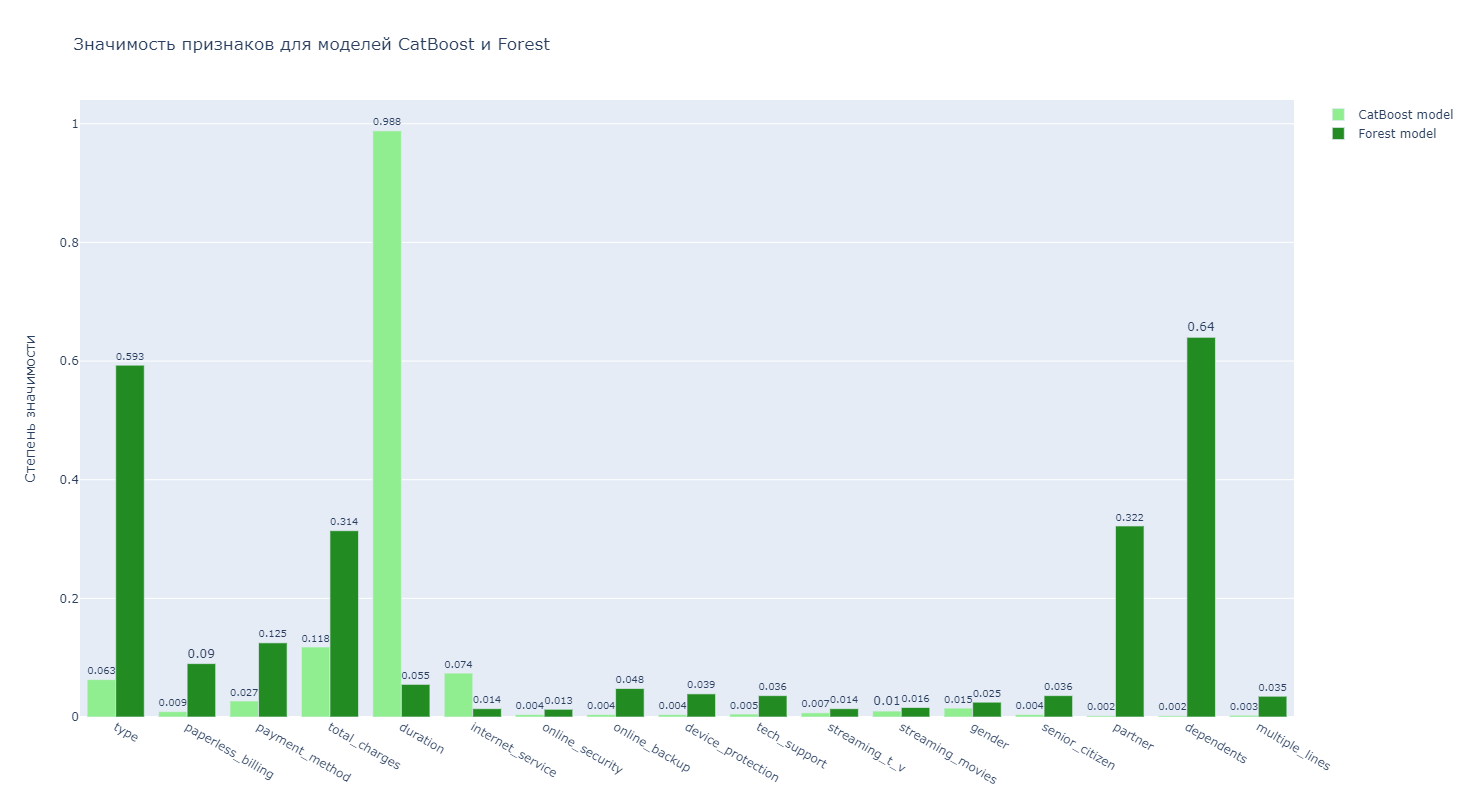

In [ ]:
cat_imp = cat_trained_model.get_feature_importance()
cat_imp_norm = [np.round(x / scipy.linalg.norm(cat_imp), 3) for x in cat_imp]

forest_imp = tree_trained_model.steps[1][1].feature_importances_
forest_imp_norm = [np.round(x / scipy.linalg.norm(forest_imp), 3) for x in forest_imp]

fig = go.Figure(layout={"height": 800})
fig.add_trace(
    go.Bar(
        x=X.columns.values,
        y=cat_imp_norm,
        name="CatBoost model",
        marker_color="lightgreen",
        text=cat_imp_norm,
        textposition="outside",
    )
)
fig.add_trace(
    go.Bar(
        x=X.columns.values,
        y=forest_imp_norm,
        name="Forest model",
        marker_color="forestgreen",
        text=forest_imp_norm,
        textposition="outside",
    )
)
fig.update_layout(
    title="Значимость признаков для моделей CatBoost и Forest",
    yaxis_title="Степень значимости",
)

fig.show()

С учетом того, что обе модели имеют в своей основе деревья решений в данном случае они ориентируются в основном на противоположные признаки. Так для модели CatBoost значимыми признаками являются `duration`, `total_charges`, `internet_service`, `type`(в порядке убывания значимости), а для модели Forest - это `dependents`, `type`, `partner` и `total_charges` (в порядке убывания значимости). Также заметно, что для обоих моделей значения признаков относящихся к наличию дополнительных услуг оператора связи имеют минимальное влияние на результат моделей. При это для модели CatBoost совершенно не важными являются признаки имеющие отношение к персональным данным клиентов. 

Попробуем усовершенствовать нашу лучшую модель. Переобучим ее только на данных имеющих значение для модели, таким образом позволив ей не отвлекаться на лишний 'шум'.<br>
Удалим из данных следующие признаки: 
- `online_security`;
- `online_backup`
- `device_protection`;
- `tech_support`;
- `senior_citizen`;
- `partner`;
- `dependents`;
- `multiple_lines`.

А затем заново обучим модель CatBoostClassifier.

In [ ]:
X_cutted_train = X_train.drop(
    [
        "online_security",
        "device_protection",
        "tech_support",
        "online_backup",
        "senior_citizen",
        "partner",
        "dependents",
        "multiple_lines",
    ],
    axis=1,
)

X_cutted_test = X_test.drop(
    [
        "online_security",
        "device_protection",
        "tech_support",
        "online_backup",
        "senior_citizen",
        "partner",
        "dependents",
        "multiple_lines",
    ],
    axis=1,
)

pool_train_cut = Pool(
    data=X_cutted_train, label=y_train, cat_features=categorical(X_cutted_train)
)
pool_test_cut = Pool(
    data=X_cutted_test, label=y_test, cat_features=categorical(X_cutted_test)
)

clf_cat_update = CatBoostClassifier(
    iterations=500,
    # early_stopping_rounds=15,
    silent=True,
    random_seed=RANDOM_STATE,
    eval_metric="AUC",
)

grid_cat_update = clf_cat_update.grid_search(
    param_grid=params_cat,
    X=pool_train_cut,
    cv=5,
    shuffle=True,
    partition_random_seed=RANDOM_STATE,
    search_by_train_test_split=True,
    calc_cv_statistics=True,
    plot=True,
    stratified=True,
    verbose=False,
)

# далее запись результатов
best_metrics.append(grid_cat_update["cv_results"]["test-AUC-mean"][-1])
results = pd.concat(
    [
        results,
        pd.DataFrame(
            best_metrics[-1], index=["CatBoostClassifier_update"], columns=["ROC_AUC"]
        ),
    ],
    axis=0,
)
cat_model_update = clf_cat_update

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.9096739059
bestIteration = 494

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 0.9286780654
bestIteration = 324

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 0.9252978789
bestIteration = 341

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 0.9184741275
bestIteration = 497

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 0.9272156653
bestIteration = 357

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 0.9252720581
bestIteration = 346

Metric AUC is not calculated on train by default. To c

In [ ]:
print(
    f"Наилучшая оценка ROC-AUC: {grid_cat_update['cv_results']['test-AUC-mean'][-1]:.4}"
)
print("У модели CatBoost с параметрами:")
pprint.pprint(grid_cat_update["params"])
results.style.highlight_max(color="olive", axis=0).format("{:.3f}")

Наилучшая оценка ROC-AUC: 0.9355
У модели CatBoost с параметрами:
{'depth': 3, 'l2_leaf_reg': 1, 'learning_rate': 0.24, 'random_strength': 1}


Можно видеть, что метрика очень незначительно но увеличилась ROC-AUC на 0,0055 и составляет 0,9355.<br>
Тогда в дальнейшем мы можем использовать именно эту модель!

## Тестирование модели

Найдем итоговую метрику ROC-AUC нашей лучшей модели на тестовых данных.

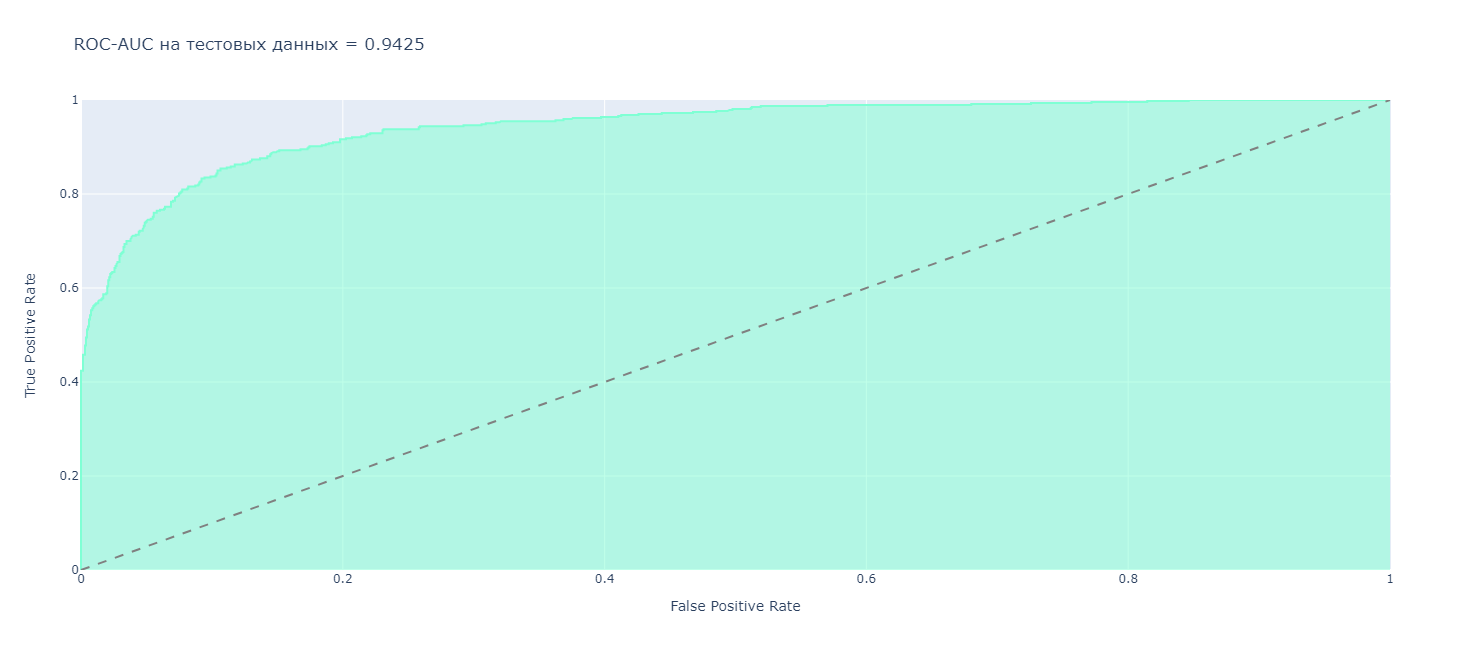

In [ ]:
probabilities = cat_model_update.predict_proba(pool_test_cut)[:, 1]
roc_auc_test = roc_auc_score(y_test, probabilities)

fpr, tpr, _ = roc_curve(y_test, probabilities)

fig = go.Figure(layout={"height": 650, "width": 650})
fig.update_yaxes(range=[0, 1])
fig.add_trace(
    go.Scatter(
        x=fpr,
        y=tpr,
        fill="tozeroy",
        line_color="aquamarine",
    )
)
fig.add_shape(type="line", line=dict(color="grey", dash="dash"), x0=0, x1=1, y0=0, y1=1)
fig.update_layout(
    title=f"ROC-AUC на тестовых данных = {roc_auc_test:.4}",
    xaxis_title="False Positive Rate",
    yaxis_title="True Positive Rate",
)
fig.show()

На тестовых данных мы получили ROC-AUC = 0,9425 - это отличный результат для нашей модели. Так же можно заметить, что метрика немного стала выше по сравнению с величиной на обучении, так что про переобучение речи не идет.

Дополнительно посмотрим какие метрики Precision и Recall можно получить меняя порог вероятности у предсказаний нашей модели.

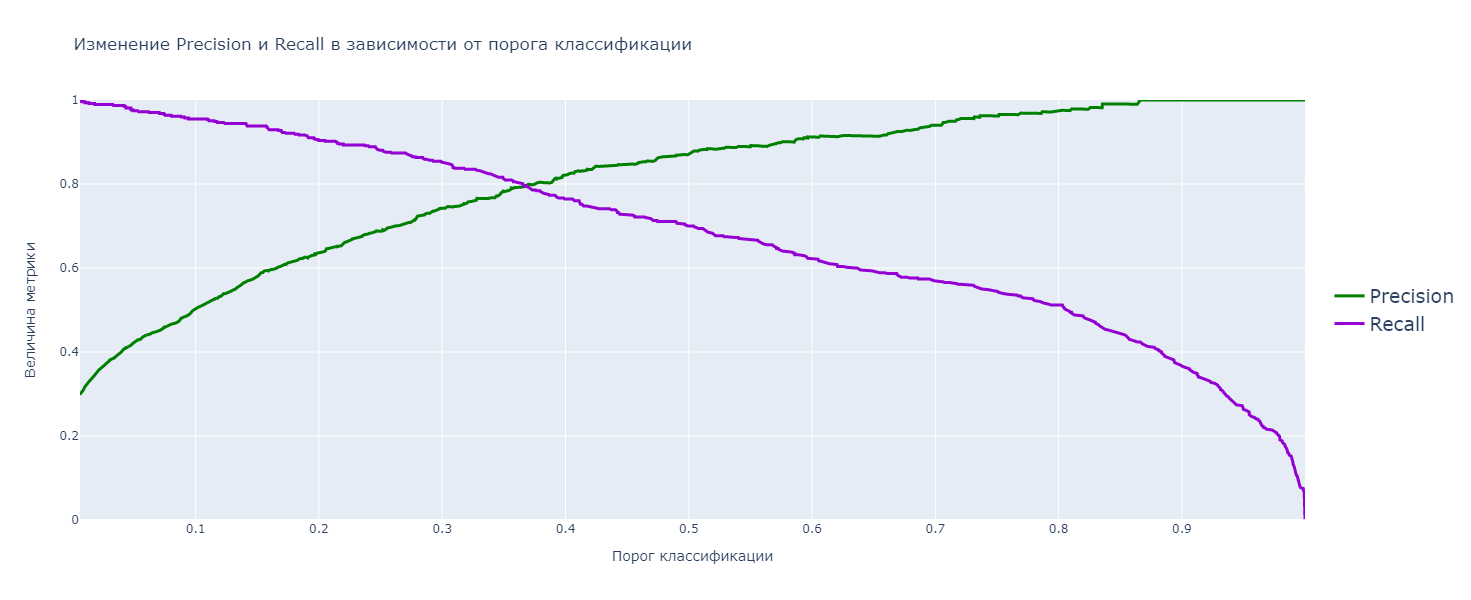

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, probabilities)

fig = go.Figure(layout={"height": 600, "width": 1200})
fig.update_yaxes(range=[0, 1])

fig.add_trace(
    go.Scatter(
        x=thresholds,
        y=precision[:-1],
        line=dict(color="green", width=3),
        name="Precision",
    )
)

fig.add_trace(
    go.Scatter(
        x=thresholds,
        y=recall[:-1],
        line=dict(color="darkviolet", width=3),
        name="Recall",
    )
)

fig.update_layout(
    legend=dict(y=0.5, font_size=19),
    title="Изменение Precision и Recall в зависимости от порога классификации",
    xaxis_title="Порог классификации",
    yaxis_title="Величина метрики",
)

По данному графику можно подобрать порог для необходимых показателей в метриках Precision и Recall, чтобы минимизировать ошибку модели в той области, которая необходима.

## Отчет по проделанной работе.

**В данном проекте необходимо было построить модель машинного обучения, способную предсказывать возможность ухода клиента от оператора связи «Ниединогоразрыва.ком» с заданной метрикой ROC-AUC больше 0,85. Основой для работы были исторические данные о клиентах за несколько лет работы. Заказчик работы предполагает использовать результаты предсказания модели для предложения клиентам, которые потенциально намереваются прервать работу с компанией, различных бонусных предложений и промокодов.**  

### Обзор данных

Для работы от заказчика были получены 4 файла с данными: персональные данные о клиентах, информация о контракте клиента и оператора, данные о интернет-подключении и дополнительных услугах клиента, данные о подключении телефонной линии. <br>
Для разведочного анализа данных была использована информация полученная из отчетов `ydata_profiling.ProfileReport`. Отчеты показали, что все 4 файла имеют столбец `customer_ID`, дающий привязку к пользователю и связь между файлами. В данных были обнаружены признаки имеющие форматы DateTime, Categorical, Boolean и Numeric. Некоторые из форматов были определены некорректно по отношению к содержанию столбцов с данными. Далее были уточнены некоторые значения признаков в данных и составлен [план](#1) работы над проектом. 

### Обработка данных

Далее, согласно плану работы, были откорректированы и приведены к snake_case все названия признаков во всех 4х файлах.<br>
Была проведена работа над столбцом `total_charges`, который при наличии цифровых значений имел формат object. В ходе конвертации формата столбца были обнаружены пропущенные значения, оказавшиеся пустующими значениями суммарных платежей совершенно новых клиентов. Пропуски были заменены нулевыми значениями, и распределение всех значений столбца `total_charges` были отражены на [графике](#2) с целью убедиться в отсутствии аномальных значений и каких-либо выбросов.<br>
Следующим плановым шагом была работа со столбцами `begin_date` и `end_date`. В данных столбцах также присутсвовал неверный формат данных, дополнительно столбец `end_date` содержал значения `No`, которые не относились к дате, но показывали продолжение работы клиента с оператором. Для этих столбцов была проведена следующая работа:
- Из столбца `end_date`, был вычленен столбец `out_or_not` с бинарным признаком, показывающим ушел клиент от оператора или продолжает с ним работу. В дальнейшим этот столбец станет нашим целевым признаком, поэтому сразу было построено и рассмотрено его [распределение](#3) в данных. По графику стало понятно, что целевой признак имеет явный дисбаланс;
- Значения `No` в столбце `end_date` были заменены на дату последнего обновления информации о клиентах перед передачей файлов к нам;
- Столбцы приведены к формат datetime;
- Из разницы столбцов была вычислена продолжительность работы с каждым клиентом в днях и переведена в числовой формат, затем записана в столбец `duration`.


После обработки значений и форматов было принято решение объеденить все таблицы в один датафрейм для корректной работы с моделями машинного обучения. Объединение было проведено по столбцу `customer_ID`. В ходе объединения таблиц появились значения с пропусками, так как в таблицах с видом интернет услуг и наличием телефонного соединения числились не все абоненты. Пропуски показывали только то, что абоненты не использовали данные услуги, поэтому они были заменены на значения `No`.  <br>
Объединенная таблица была проверена на корреляцию признаков между собой и на влияние на целевой параметр. Многие параметры имеющие отношения к услугам провайдера имели довольно большую корреляцию с признаком `monthly_charges`, но большого влияния на наш целевой параметр не показал ни один параметр. <br>
Перед передачей данных моделям было принято решение об удалении столбцов `end_date` и `begin_date` для устранения возможной утечки данных, и также столбца `monthly_charges` так как он является собирательным признаком и зависит от количества и видов услуг, которые использует абонент.

### Подготовка к работе моделей

При подготовке к работе моделей целевой признак был выделен в отдельную переменную. Далее данные были разделены на тренировочную часть и на тестовую часть, тестовая часть составила 25% от общих данных. При разделении была применена стратификация по целевому признаку и перемешивание данных.<br>


Так как от заказчика поступило требование в работе ориентироваться на метрику ROC-AUC, то пункт первоначального плана по подготовке параметра scoring был пропущен - все модели с которыми мы работаем имееют встроенную метрику ROC-AUC.<br>  

Для поиска лучшего решения над поставленной задачей было запланировано проверить работу следующих моделей машинного обучения, решающих задачу бинарной классификации:

- DecisionTreeClassifier - Модель решающего дерева;
- RandomForestClassifier - Модель случайного леса решающих деревьев;
- LogisticRegression - Простую логистическую регресию;
- SVC - Модель опорных векторов;
- CatBoostClassifier - Модель градиентного бустинга.

Модели были разделены на группы по предпочтительной предобработке данных и подготовлены трансформеры: 

- Для моделей LogisticRegression и SVC сделали `transformer_lin_models` - трансформер, который преобразовывает категориальные признаки методом `OneHot`,  а числовые признаки масштабирует с помощью  `MinMaxScaler()`;
- Для моделей DecisionTreeClassifier и RandomForestClassifier сделали `transformer_tree_models` - трансформер, который  преобразовывает категориальные признаки через `OrdinalEncoder()`, а числовые оставляет без изменения;
- Для модели CatBoostClassifier вся предобработка данных будет происходить внутри модели.

Также подготовлены объекты `pipeline` и гиперпараметры для моделей, среди которых происходил поиск оптимального набора.<br>
Обучение моделей и подбор гиперпараметров для моделей из первых 2х групп было решено проводить с помощью RandomizedSearchCV с проверкой на кроссвалидации. Для модели CatBoostClassifier подбор гиперпараметров и кроссвалидация был осуществлен внутренними методами самой модели.

### Обучение моделей и анализ значимости признаков

Далее было проведено непосредственное обучение моделей с подбором оптимальных гиперпараметров и в каждой группе моделей появилась модель с лучшими результатами по метрике ROC-AUC:

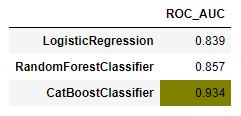

По таблице видно, что лучше всех отработала модель CatBoostClassifier, получившая метрику ROC-AUC на кроссвалидации = 0,934. Отрыв от остальных моделей был весьма существенным: следующая успешная модель оказалась RandomForestClassifier с оценкой ROC-AUC = 0,857.<br>
Затем  было принято решение провести анализ значимости признаков на работу двух лучших моделей. По нормализованной степени значимости признаков был построен следующий график: 

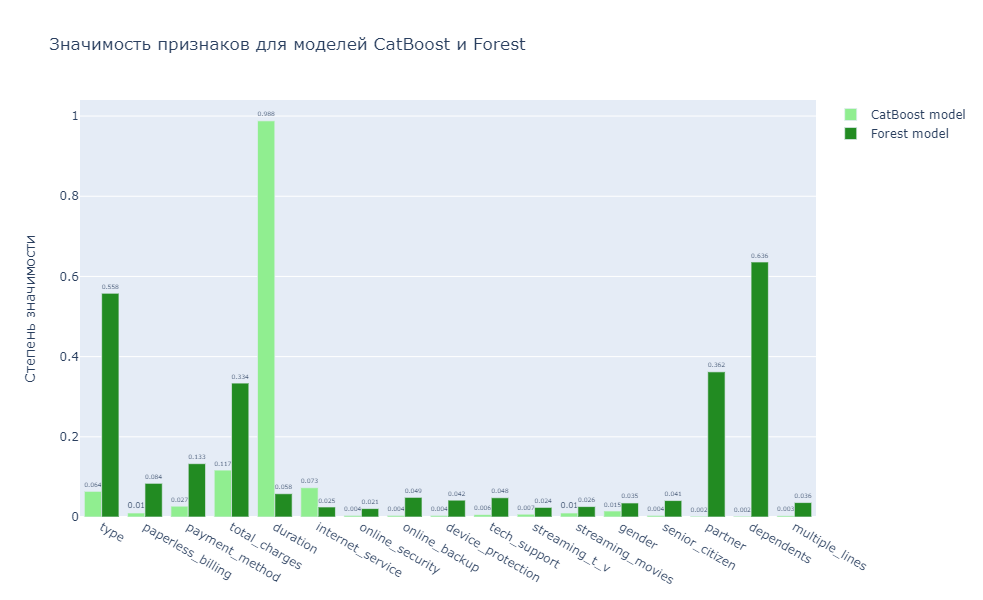

График значимости признаков показал, что на нашу самую успешную модель CatBoostClassifier имеют влияние далеко не все признаки, присутствующие в наших данных. Основное влияние дают следующие признаки: `duration`, `total_charges`, `internet_service`, `type`(в порядке убывания значимости). После анализа графика значимости признаков было принято решение избавиться от самых несущественных по влиянию признаков и заново обучить модель CatBoostClassifier с подбором гиперпараметров. Были отброшены следующие признаки: 
- `online_security`;
- `online_backup`
- `device_protection`;
- `tech_support`;
- `senior_citizen`;
- `partner`;
- `dependents`;
- `multiple_lines`.

После этого модель была записана в переменную CatBoostClassifier_update	и получила следующую оценку на обучающих данных:

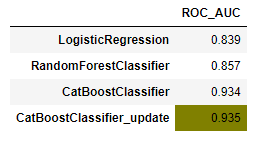

Таким образом оценка изменилась незначительно, но вверх.<br>

По итогу мы получили обученную модель CatBoostClassifier_update готовую к тестированию и имеющую следующие параметры:
- `depth` = 3;
- `l2_leaf_reg` = 1;
- `learning_rate` = 0.24;
- `random_strength` = 1;
- `iterations` = 500;
- `random_seed` = 130323;
- `eval_metric` = `AUC`.

Данная модель работает только со следующими признаками:
- `type`;
- `paperless_billing`;
- `payment_method`;
- `total_charges`;
- `duration`;
- `internet_service`;
- `streaming_t_v`;
- `streaming_movies`;
- `gender`.


### Тестирование модели и итоговые метрики

На тестовых данных у нашей модели CatBoostClassifier_update получилась метрика ROC-AUC = 0,9425 - это отличный результат для данной работы. Дополнительно мы изобразили ее на графике зависимости True Positive Rate от False Positive Rate.<br>
По графику можно наблюдать как при изменении порога классификации меняется доля верно предсказанных объектов к общему числу объектов класса(TPR) и при этом увеличивается также доля ложных срабатываний к общему числу объектов за пределами класса(FPR).

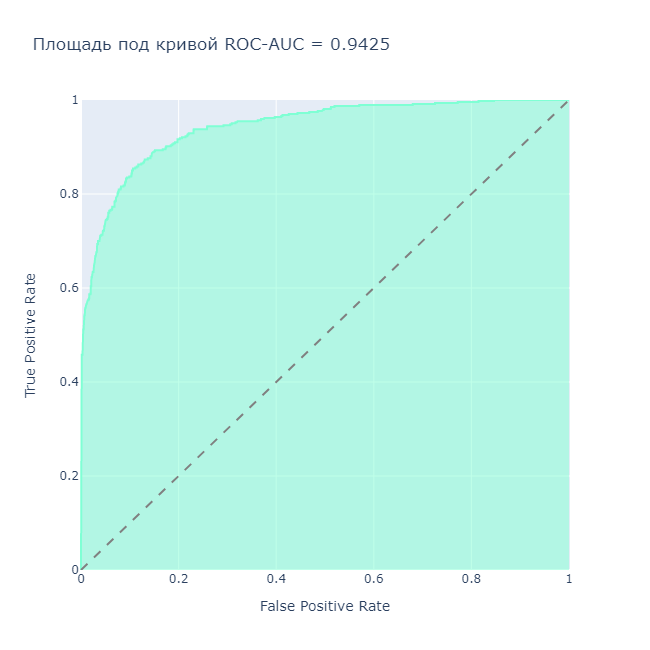

Для большей наглядности был также построен график изменения метрик Precision и Recall в зависимости от изменения порога классификации предсказаний модели:

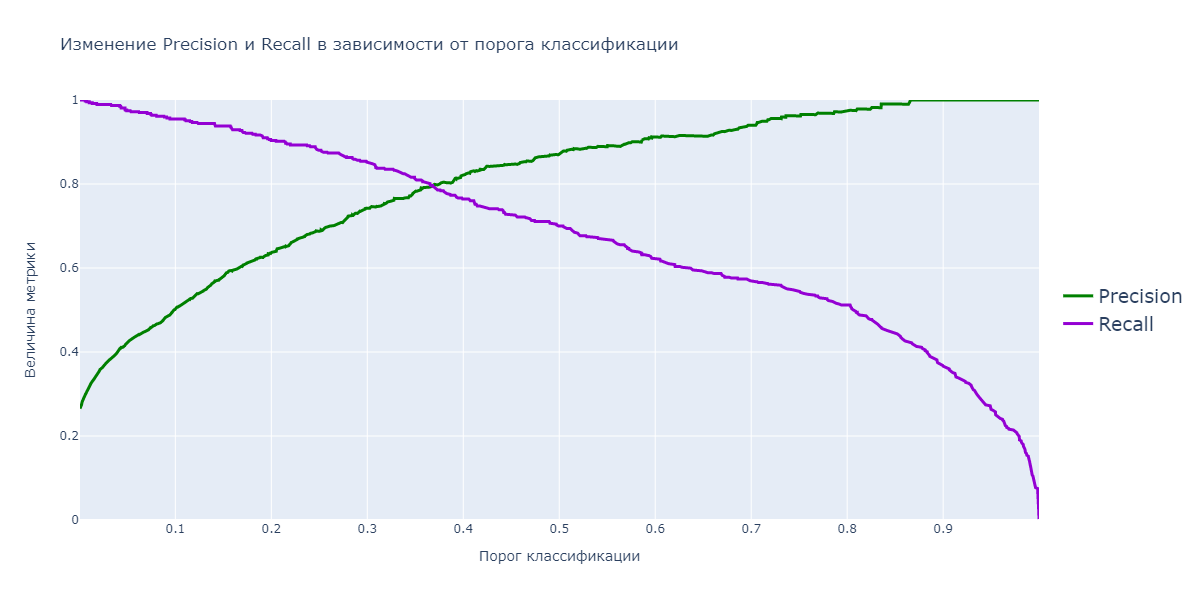

По данному графику заказчик самостоятельно сможет менять порог классификации предсказаний модели чтобы получать больший выигрыш в той метрике, которая необходимо на момент принятия решений.<br>

По графику мы видим, что при увеличении порога примерно до 0,85, мы получаем практически самые высокие показатели метрики Precision, что позволяет нам минимально ошибаться при предложении бонусных предложений и промокодов клиентам; при этом метрика Recall опускается до уровня 0,4 - и показывает, что большая часть клиентов, собирающихся уйти, предложение на промокод так и не получат.<br>
В обратной ситуации - при установке порога классификации на уровне 0,1 мы получаем практически идельную Recall, что означает, что промоды и спец. предложения получат все клиенты, собирающиеся уходить, но так же и часть клиентов, никуда не собирающихся - это нам показывает метрика Precision имеющая, при таком пороге значения в районе 0,5.<br>

В качестве рекомендации работы с порогом классификации можно посоветовать ранжировать спец.предложения и промокоды по их ценности для компании-заказчика. Использовать наиболее ценные из спец.предложений для клиентов, которых модель определяет с высоким порогом классификации > 0,8. А для клиентов, определяемых с порогом подходящим минимально терпимой Precision и не вошедших в первую группу, использовать спец.предложения, имеющие среднюю ценность и стоимость затрат для компании. Таким образом, возможно снизить издержки на спец.предложения для клиентов, определенных ошибочно, и максимально охватить клиентов, которых компания стремится сохранить.

 **В итоге мы имеем модель CatBoostClassifier_update с метрикой  ROC-AUC = 0,9425 обученную, готовую для передачи передачи заказчику и последующей работы в проектах компании.**